In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [5]:
import rasterio
import numpy as np
import gdal
import pandas as pd
import operator
import gc
import os
from osgeo import gdal_array
import matplotlib.pyplot as plt

gdalwarp function in QGIS to transfer the two raster images (i.e., CDL.tif and RapidEye.tif) into the same projections. In the following, out_cdl.tif has the same resolution (9210 * 11652) with RapidEye.tif . 

In [ ]:
metadata = os.popen('gdalinfo -mm ./drive/MyDrive/App/data/RapidEye.tif').read()
print(metadata)

Driver: GTiff/GeoTIFF
Files: ./drive/MyDrive/App/data/RapidEye.tif
Size is 9210, 11652
Coordinate System is:
PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-87],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32616"]]
Origin = (374955.000000000000000,4473075.000000000000000)
Pixel Size = (5.000000000000000,-5.000000000000000)
Metadata:
  A

In [8]:
cdl_ds = rasterio.open('./drive/MyDrive/App/data/out_cdl.tif')
cdl=cdl_ds.read(1)
train_ds = rasterio.open('/content/drive/MyDrive/App/data/RapidEye.tif')
img_train = train_ds.read() #img_train.shape is (5, 11652, 9210)
print(cdl.shape, img_train.shape)

(11652, 9210) (5, 11652, 9210)


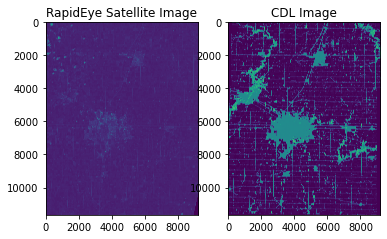

In [10]:
# Display RapidEye satellite and CDL images
plt.subplot(121)
plt.imshow(img_train[1,:,:])
plt.title('RapidEye Satellite Image')

plt.subplot(122)
plt.imshow(cdl)#, cmap=plt.cm.Spectral)
plt.title('CDL Image')

plt.show()

In [ ]:
classes = np.unique(cdl)
dict = {}
# how many pixels for each class?
for c in classes:
    dict[c] = (cdl == c).sum()
sorted_x = sorted(dict.items(), key=operator.itemgetter(1))
print("Top 10 classes and pixel counts \n",sorted_x[-10:])

Top 10 classes and pixel counts 
 [(124, 393084), (24, 498852), (123, 1200888), (141, 1765188), (0, 3944988), (176, 4153464), (121, 4446180), (122, 5517324), (5, 38434464), (1, 46251288)]


In [11]:
class_3=[124, 24, 123, 141, 0, 176, 121, 122]
top_classes = [5,1]

In [12]:
final = pd.DataFrame()
for c in class_3:
  Xt = img_train[:,cdl==c] 
  Xt1 = pd.DataFrame(Xt.T)
  Xt1["class"] = 3 
  final = pd.concat([Xt1,final],axis=0)
  final.reset_index(drop=True,inplace=True)

print('We have {n} samples for class 3, select 20,000,000'.format(n=final.shape[0]))
final = final.sample(n=20000000)
final.reset_index(drop=True,inplace=True)

for c in top_classes:
  Xt = img_train[:,cdl==c] 
  print('We have {n} samples for class {c}, select 20,000,000'.format(n=Xt.shape[1],
                                                   c=c))
  Xt1 = pd.DataFrame(Xt.T)
  Xt2 = Xt1.sample(n=20000000)
  Xt2.reset_index(drop=True,inplace=True)
  Xt2["class"] = c 
  final = pd.concat([Xt2,final],axis=0)
  final.reset_index(drop=True,inplace=True)

### Calculate Vegetation Index from the 5 bands
### NDVI = (NIR-R)/(NIR+R)
#ndvi = (final.loc[:,final.columns[4]] - final.loc[:,final.columns[2]]) / (final.loc[:,final.columns[4]] + final.loc[:,final.columns[2]])
#final['NDVI'] = ndvi
### SAVI = 1.5*(NIR-R)/(NIR+R+0.5)
#savi = 1.5*(final.loc[:,final.columns[4]] - final.loc[:,final.columns[2]]) / (final.loc[:,final.columns[4]] + final.loc[:,final.columns[2]]+0.5)
#final['SAVI'] = savi
### RECI : NIR/R-1
#reci = final.loc[:,final.columns[4]] / final.loc[:,final.columns[2]] - 1
#final['RECI'] = reci
### NDRE = (NIR – RED EDGE) / (NIR + RED EDGE)
#ndre = (final.loc[:,final.columns[4]] - final.loc[:,final.columns[3]]) / (final.loc[:,final.columns[4]] + final.loc[:,final.columns[3]])
#final['NDRE'] = ndre
### GNDVI = (NIR – GREEN) / (NIR + GREEN)
#gndvi = (final.loc[:,final.columns[4]] - final.loc[:,final.columns[1]]) / (final.loc[:,final.columns[4]] + final.loc[:,final.columns[1]])
#final['NDRE'] = gndvi
### NDWI = (GREEN – NIR) / (GREEN + NIR)
#ndwi = (final.loc[:,final.columns[1]] - final.loc[:,final.columns[4]]) / (final.loc[:,final.columns[1]] + final.loc[:,final.columns[4]])
#final['NDWI'] = ndwi
### EVI = 2.5 * ((NIR – RED) / ((NIR) + (6 * RED) – (7.5 * BLUE) + 1))
#evi = 2.5 * (final.loc[:,final.columns[4]] - final.loc[:,final.columns[2]]) / (final.loc[:,final.columns[4]] + 6 * final.loc[:,final.columns[2]] - 7.5 * final.loc[:,final.columns[0]] + 1)
#final['EVI'] = evi
### ARVI = (NIR – (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)
#avri = (final.loc[:,final.columns[4]] - (2 * final.loc[:,final.columns[2]]) + final.loc[:,final.columns[0]]) / (final.loc[:,final.columns[4]] + (2 * final.loc[:,final.columns[2]]) + final.loc[:,final.columns[0]])
#final['AVRI'] = avri
### VARI = (GREEN – RED) / (GREEN + RED – BLUE)
#vari = (final.loc[:,final.columns[1]] - final.loc[:,final.columns[2]]) / (final.loc[:,final.columns[1]] + final.loc[:,final.columns[2]] - final.loc[:,final.columns[0]])
#final['VARI'] = vari
### SIPI = (NIR – BLUE) / (NIR – RED)
#sipi = (final.loc[:,final.columns[4]] - final.loc[:,final.columns[0]]) / (final.loc[:,final.columns[4]] - final.loc[:,final.columns[2]])
#final['SIPI'] = sipi
### GCI = NIR / GREEN – 1
#gci = final.loc[:,final.columns[4]] / final.loc[:,final.columns[1]] - 1
#final['GCI'] = gci   


We have 21919968 samples for class 3, select 20,000,000
We have 38434464 samples for class 5, select 20,000,000
We have 46251288 samples for class 1, select 20,000,000


In [13]:
final

,0,1,2,3,4,class
0,4919.0,4442.0,2449.0,3976.0,11384.0,1
1,5016.0,3898.0,2113.0,3302.0,11881.0,1
2,4830.0,3758.0,1970.0,3044.0,11257.0,1
3,5070.0,4150.0,2232.0,3717.0,12941.0,1
4,5180.0,3800.0,2173.0,3352.0,11602.0,1
...,...,...,...,...,...,...
59999995,5238.0,4257.0,2270.0,3926.0,9331.0,3
59999996,6824.0,6438.0,5071.0,5527.0,9150.0,3
59999997,19181.0,18223.0,15788.0,12245.0,11135.0,3
59999998,5441.0,4692.0,2917.0,4832.0,10213.0,3


In [ ]:
final.columns = ['col_'+str(i) for i in range(6)]
final.to_csv("/content/drive/MyDrive/App/data/final.csv",index=False)